In [10]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("requiemonk/sentinel12-image-pairs-segregated-by-terrain")

print("Path to dataset files:", path)

/home/rohith/Downloads/sar_image_colorization_gan-main/venv/lib64/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/rohith/.cache/kagglehub/datasets/requiemonk/sentinel12-image-pairs-segregated-by-terrain/versions/1


In [11]:
import os

directory = "/home/rohith/.cache/kagglehub/datasets/requiemonk/sentinel12-image-pairs-segregated-by-terrain/versions/1/v_2"
files = os.listdir(directory)

for file in files:
    print(file)

urban
agri
grassland
barrenland


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision import models
import numpy as np
from tqdm import tqdm
import os
from PIL import Image
import random

In [13]:

torch.manual_seed(42)
random.seed(42)
np.random.seed(42)


class SARColorizationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_pairs = self._load_image_pairs()

    def _load_image_pairs(self):
        image_pairs = []
        land_types = ["agri", "barrenland", "grassland", "urban"]

        for land in land_types:
            sar_dir = os.path.join(self.root_dir, land, "s1")
            optical_dir = os.path.join(self.root_dir, land, "s2")


            if not os.path.exists(sar_dir) or not os.path.exists(optical_dir):
                print(f"Skipping {land} because directories are missing.")
                continue


            sar_files = [f for f in os.listdir(sar_dir) if "_s1_" in f]
            optical_files = [f for f in os.listdir(optical_dir) if "_s2_" in f]

            sar_base = {f.replace("_s1_", ""): f for f in sar_files}
            optical_base = {f.replace("_s2_", ""): f for f in optical_files}


            common_basenames = set(sar_base.keys()).intersection(set(optical_base.keys()))

            for base in common_basenames:
                sar_path = os.path.join(sar_dir, sar_base[base])
                optical_path = os.path.join(optical_dir, optical_base[base])
                image_pairs.append((sar_path, optical_path))

        return image_pairs

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        sar_path, optical_path = self.image_pairs[idx]
        sar_image = Image.open(sar_path).convert("L")  # Convert to grayscale
        optical_image = Image.open(optical_path).convert("RGB")  # Convert to RGB

        if self.transform:
            sar_image = self.transform(sar_image)
            optical_image = self.transform(optical_image)

        return sar_image, optical_image

#Transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])

In [14]:
from torch.utils.data import random_split
dataset = SARColorizationDataset(root_dir="/home/rohith/.cache/kagglehub/datasets/requiemonk/sentinel12-image-pairs-segregated-by-terrain/versions/1/v_2/", transform=transform)
train_size = int(0.9 * len(dataset))  
test_size = len(dataset) - train_size  

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

#sizes of the splits
print(f"Training dataset size: {len(train_dataset)}")
print(f"Testing dataset size: {len(test_dataset)}")
#DataLoaders for train and test sets
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)  

Training dataset size: 14400
Testing dataset size: 1600


In [15]:
print(f"Number of batches in train_loader: {len(train_loader)}")
print(f"Number of batches in test_loader: {len(test_loader)}")

Number of batches in train_loader: 900
Number of batches in test_loader: 100


In [16]:
# pix-2-pix model
class DownsamplingBlock(nn.Module):
    def __init__(self, c_in, c_out, kernel_size=4, stride=2, padding=1, negative_slope=0.2, use_norm=True):
        super(DownsamplingBlock, self).__init__()
        block = [nn.Conv2d(c_in, c_out, kernel_size, stride, padding, bias=not use_norm)]
        if use_norm:
            block.append(nn.BatchNorm2d(c_out))
        block.append(nn.LeakyReLU(negative_slope))
        self.conv_block = nn.Sequential(*block)

    def forward(self, x):
        return self.conv_block(x)

class UpsamplingBlock(nn.Module):
    def __init__(self, c_in, c_out, kernel_size=4, stride=2, padding=1, use_dropout=False, use_upsampling=False, mode='nearest'):
        super(UpsamplingBlock, self).__init__()
        block = []
        if use_upsampling:
            block.append(nn.Sequential(
                nn.Upsample(scale_factor=2, mode=mode),
                nn.Conv2d(c_in, c_out, 3, 1, padding, bias=False)
            ))
        else:
            block.append(nn.ConvTranspose2d(c_in, c_out, kernel_size, stride, padding, bias=False))
        block.append(nn.BatchNorm2d(c_out))
        if use_dropout:
            block.append(nn.Dropout(0.5))
        block.append(nn.ReLU())
        self.conv_block = nn.Sequential(*block)

    def forward(self, x):
        return self.conv_block(x)

class UnetEncoder(nn.Module):
    def __init__(self, c_in=3, c_out=512):
        super(UnetEncoder, self).__init__()
        self.enc1 = DownsamplingBlock(c_in, 64, use_norm=False)
        self.enc2 = DownsamplingBlock(64, 128)
        self.enc3 = DownsamplingBlock(128, 256)
        self.enc4 = DownsamplingBlock(256, 512)
        self.enc5 = DownsamplingBlock(512, 512)
        self.enc6 = DownsamplingBlock(512, 512)
        self.enc7 = DownsamplingBlock(512, 512)
        self.enc8 = DownsamplingBlock(512, c_out)

    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(x1)
        x3 = self.enc3(x2)
        x4 = self.enc4(x3)
        x5 = self.enc5(x4)
        x6 = self.enc6(x5)
        x7 = self.enc7(x6)
        x8 = self.enc8(x7)
        return [x8, x7, x6, x5, x4, x3, x2, x1]

class UnetDecoder(nn.Module):
    def __init__(self, c_in=512, c_out=64, use_upsampling=False, mode='nearest'):
        super(UnetDecoder, self).__init__()
        self.dec1 = UpsamplingBlock(c_in, 512, use_dropout=True, use_upsampling=use_upsampling, mode=mode)
        self.dec2 = UpsamplingBlock(1024, 512, use_dropout=True, use_upsampling=use_upsampling, mode=mode)
        self.dec3 = UpsamplingBlock(1024, 512, use_dropout=True, use_upsampling=use_upsampling, mode=mode)
        self.dec4 = UpsamplingBlock(1024, 512, use_upsampling=use_upsampling, mode=mode)
        self.dec5 = UpsamplingBlock(1024, 256, use_upsampling=use_upsampling, mode=mode)
        self.dec6 = UpsamplingBlock(512, 128, use_upsampling=use_upsampling, mode=mode)
        self.dec7 = UpsamplingBlock(256, 64, use_upsampling=use_upsampling, mode=mode)
        self.dec8 = UpsamplingBlock(128, c_out, use_upsampling=use_upsampling, mode=mode)

    def forward(self, x):
        x9 = torch.cat([x[1], self.dec1(x[0])], 1)
        x10 = torch.cat([x[2], self.dec2(x9)], 1)
        x11 = torch.cat([x[3], self.dec3(x10)], 1)
        x12 = torch.cat([x[4], self.dec4(x11)], 1)
        x13 = torch.cat([x[5], self.dec5(x12)], 1)
        x14 = torch.cat([x[6], self.dec6(x13)], 1)
        x15 = torch.cat([x[7], self.dec7(x14)], 1)
        out = self.dec8(x15)
        return out

class UnetGenerator(nn.Module):
    def __init__(self, c_in=3, c_out=3, use_upsampling=False, mode='nearest'):
        super(UnetGenerator, self).__init__()
        self.encoder = UnetEncoder(c_in=c_in)
        self.decoder = UnetDecoder(use_upsampling=use_upsampling, mode=mode)
        self.head = nn.Sequential(
            nn.Conv2d(64, c_out, 3, 1, padding=1, bias=True),
            nn.Tanh()
        )

    def forward(self, x):
        outE = self.encoder(x)
        outD = self.decoder(outE)
        out = self.head(outD)
        return out

class PatchDiscriminator(nn.Module):
    def __init__(self, c_in=3, c_hid=64, n_layers=3):
        super(PatchDiscriminator, self).__init__()
        model = [DownsamplingBlock(c_in, c_hid, use_norm=False)]
        n_p, n_c = 1, 1
        for n in range(1, n_layers):
            n_p, n_c = n_c, min(2**n, 8)
            model.append(DownsamplingBlock(c_hid*n_p, c_hid*n_c))
        n_p, n_c = n_c, min(2**n_layers, 8)
        model.append(DownsamplingBlock(c_hid*n_p, c_hid*n_c, stride=1))
        model.append(nn.Conv2d(c_hid*n_c, 1, 4, 1, padding=1, bias=True))
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

In [17]:
# optimizers and hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = UnetGenerator(c_in=1, c_out=3).to(device)
discriminator = PatchDiscriminator(c_in=4).to(device)  

optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

criterion_GAN = nn.BCEWithLogitsLoss()
criterion_L1 = nn.L1Loss()


In [18]:
import random
import matplotlib.pyplot as plt

def plot_images(generator, test_loader, device, epoch=None):
    """
    Plot SAR, generated optical, and real optical images for 3 random samples.

    Args:
        generator (nn.Module): The generator model.
        test_loader (DataLoader): DataLoader for the test dataset.
        device (torch.device): Device to run the generator on (e.g., "cuda" or "cpu").
        epoch (int, optional): Current epoch (for title). If None, no epoch is displayed.
    """
    generator.eval()  
    with torch.no_grad(): 
 
        dataset = test_loader.dataset
        indices = random.sample(range(len(dataset)), 3) 
        samples = [dataset[i] for i in indices]  


        sar_images = []
        optical_images = []
        fake_optical_images = []

        
        for sar, optical in samples:
            sar = sar.unsqueeze(0).to(device)  
            fake_optical = generator(sar).cpu() 

 
            sar = sar.cpu().squeeze(0)
            optical = optical.squeeze(0)
            fake_optical = fake_optical.squeeze(0)

           
            if sar.dim() == 2:  
                sar = sar.unsqueeze(0)
            sar = sar.permute(1, 2, 0).numpy()

            if optical.dim() == 2:
                optical = optical.unsqueeze(0)
            optical = optical.permute(1, 2, 0).numpy()

            if fake_optical.dim() == 2:  
                fake_optical = fake_optical.unsqueeze(0)
            fake_optical = fake_optical.permute(1, 2, 0).numpy()

           
            sar = (sar + 1) / 2  
            optical = (optical + 1) / 2  
            fake_optical = (fake_optical + 1) / 2 

          
            sar_images.append(sar)
            optical_images.append(optical)
            fake_optical_images.append(fake_optical)

      
        fig, axes = plt.subplots(3, 3, figsize=(9, 9)) 
        fig.subplots_adjust(wspace=0.1, hspace=0.3) 

        for i in range(3):
            # SAR Image
            axes[0, i].imshow(sar_images[i], cmap="gray")
            axes[0, i].set_title("SAR Image")
            axes[0, i].axis("off")

            # Generated Optical Image
            axes[1, i].imshow(fake_optical_images[i])
            axes[1, i].set_title("Generated Optical")
            axes[1, i].axis("off")

            # Real Optical Image
            axes[2, i].imshow(optical_images[i])
            axes[2, i].set_title("Real Optical")
            axes[2, i].axis("off")


        if epoch is not None:
            fig.suptitle(f"Epoch {epoch}", fontsize=16)


        plt.show()
    generator.train()  

In [24]:
import torch
from tqdm import tqdm

def fit(
    generator, discriminator, train_loader, test_loader, optimizer_G, optimizer_D, criterion_GAN, criterion_L1, device,
    start_epoch, num_epochs, save_freq=10, plot_freq=5):
    """
    train the Pix2Pix model.

    args:
        generator (nn.Module): The generator model.
        discriminator (nn.Module): The discriminator model.
        train_loader (DataLoader): DataLoader for the training dataset.
        test_loader (DataLoader): DataLoader for the test dataset.
        optimizer_G (torch.optim): Optimizer for the generator.
        optimizer_D (torch.optim): Optimizer for the discriminator.
        criterion_GAN (nn.Module): GAN loss function.
        criterion_L1 (nn.Module): L1 loss function.
        device (torch.device): Device to run the training on (e.g., "cuda" or "cpu").
        start_epoch (int): Epoch to start training from (useful for resuming training).
        num_epochs (int): Total number of epochs to train.
        save_freq (int): Frequency (in epochs) to save the model. Default is 10.
        plot_freq (int): Frequency (in epochs) to plot images. Default is 5.
    """
    for epoch in range(start_epoch, start_epoch + num_epochs):
        for i, (input_images, target_images) in enumerate(tqdm(train_loader)):
            input_images = input_images.to(device)
            target_images = target_images.to(device)

            # train Discriminator
            optimizer_D.zero_grad()
            fake_images = generator(input_images)
            real_AB = torch.cat([input_images, target_images], dim=1)
            fake_AB = torch.cat([input_images, fake_images.detach()], dim=1)
            pred_real = discriminator(real_AB)
            pred_fake = discriminator(fake_AB)
            loss_D_real = criterion_GAN(pred_real, torch.ones_like(pred_real))
            loss_D_fake = criterion_GAN(pred_fake, torch.zeros_like(pred_fake))
            loss_D = (loss_D_real + loss_D_fake) * 0.5
            loss_D.backward()
            optimizer_D.step()

            # train Generator
            optimizer_G.zero_grad()
            fake_AB = torch.cat([input_images, fake_images], dim=1)
            pred_fake = discriminator(fake_AB)
            loss_G_GAN = criterion_GAN(pred_fake, torch.ones_like(pred_fake))
            loss_G_L1 = criterion_L1(fake_images, target_images)
            loss_G = loss_G_GAN + 100 * loss_G_L1
            loss_G.backward()
            optimizer_G.step()

        # print losses
        print(f"Epoch [{epoch+1}/{start_epoch + num_epochs}], Loss D: {loss_D.item()}, Loss G: {loss_G.item()}")

        # Plot images after every `plot_freq` epochs
        if (epoch + 1) % plot_freq == 0:
            plot_images(
                generator=generator,
                test_loader=test_loader,
                device=device,
                epoch=epoch + 1  # Add epoch number to the title
            )

        # save model after every `save_freq` epochs
        if (epoch + 1) % save_freq == 0:
            torch.save({
                'epoch': epoch + 1,
                'generator_state_dict': generator.state_dict(),
                'discriminator_state_dict': discriminator.state_dict(),
                'optimizer_G_state_dict': optimizer_G.state_dict(),
                'optimizer_D_state_dict': optimizer_D.state_dict(),
                'loss_D': loss_D,
                'loss_G': loss_G,
            }, f"checkpoint_epoch_{epoch + 1}.pth")
            print(f"Checkpoint saved at epoch {epoch + 1}")

In [20]:

fit(
    generator=generator,
    discriminator=discriminator,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer_G=optimizer_G,
    optimizer_D=optimizer_D,
    criterion_GAN=criterion_GAN,
    criterion_L1=criterion_L1,
    device=device,
    start_epoch=0,
    num_epochs=200,
    save_freq=10,  # 10 epochs
    plot_freq=5    # 5 epochs
)

  0%|          | 0/900 [00:00<?, ?it/s]


KeyboardInterrupt: 

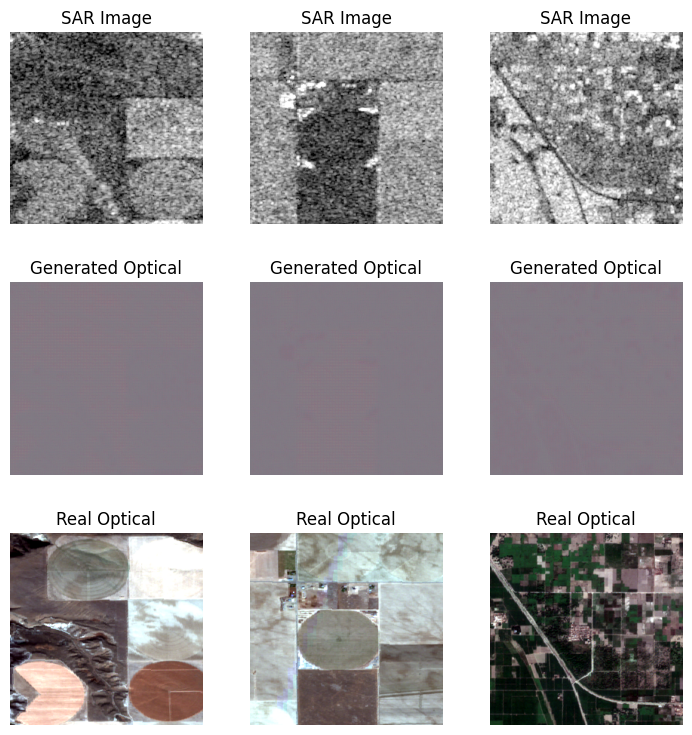

In [25]:
plot_images(
    generator=generator,
    test_loader=test_loader,
    device=device,
    epoch=None  # No epoch number in the title
)

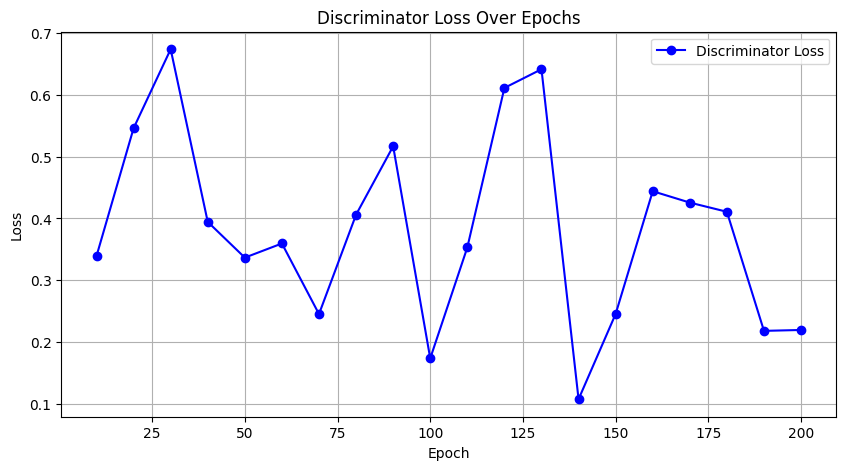

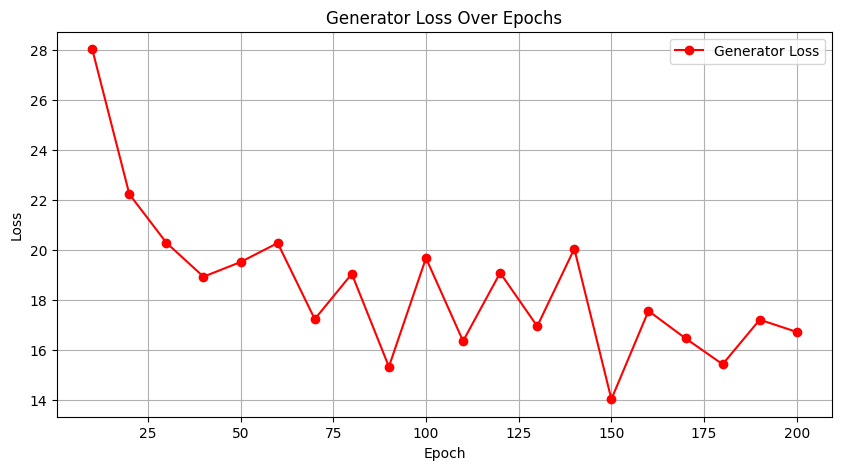

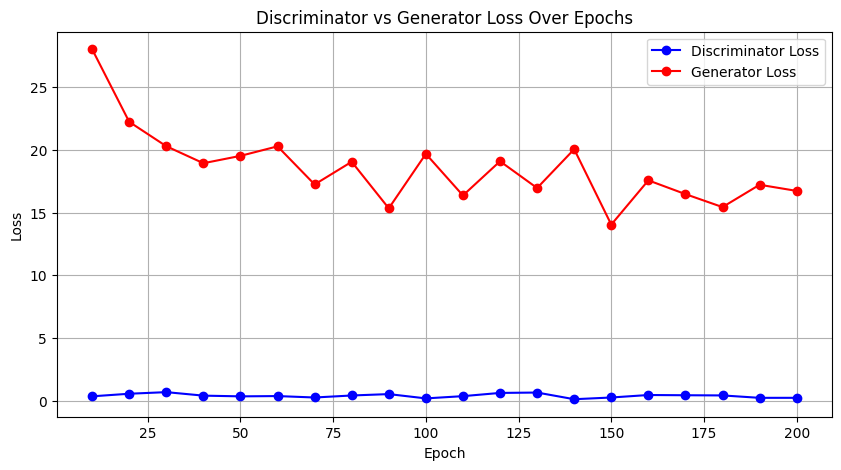

In [26]:
import torch
import matplotlib.pyplot as plt

epochs = []
loss_D_list = []
loss_G_list = []

for epoch in range(10, 201, 10):
    checkpoint_path = f"checkpoint_epoch_{epoch}.pth" 
    checkpoint = torch.load(checkpoint_path)  

    epochs.append(epoch)
    loss_D_list.append(checkpoint['loss_D'].item())  
    loss_G_list.append(checkpoint['loss_G'].item())  

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_D_list, label="Discriminator Loss", color='blue', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Discriminator Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_G_list, label="Generator Loss", color='red', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Generator Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_D_list, label="Discriminator Loss", color='blue', marker='o')
plt.plot(epochs, loss_G_list, label="Generator Loss", color='red', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Discriminator vs Generator Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

In [27]:
check_path = "checkpoint_epoch_200.pth"
checkpoint = torch.load(check_path)

In [28]:
print(checkpoint.keys())

dict_keys(['epoch', 'generator_state_dict', 'discriminator_state_dict', 'optimizer_G_state_dict', 'optimizer_D_state_dict', 'loss_D', 'loss_G'])


In [29]:
import torch
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from torchvision.utils import save_image
import os
from pytorch_fid import fid_score

generator.eval()


fake_images = []
target_images = []

with torch.no_grad():
    for input_images, target in test_loader:
        input_images = input_images.to(device)
        target = target.to(device)

        fake = generator(input_images)

        fake_images.append(fake.cpu())
        target_images.append(target.cpu())


fake_images = torch.cat(fake_images, dim=0)
target_images = torch.cat(target_images, dim=0)

fake_images_np = fake_images.numpy()
target_images_np = target_images.numpy()

#  SSIM and PSNR
ssim_values = []
psnr_values = []
for i in range(fake_images_np.shape[0]):
    ssim_values.append(ssim(fake_images_np[i], target_images_np[i], channel_axis=0, data_range=1.0))  
    psnr_values.append(psnr(target_images_np[i], fake_images_np[i], data_range=1.0))


mean_ssim = np.mean(ssim_values)
mean_psnr = np.mean(psnr_values)

print(f"Mean SSIM: {mean_ssim}")
print(f"Mean PSNR: {mean_psnr}")


def save_images(images, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    for i, img in enumerate(images):
        save_image(img, os.path.join(save_dir, f"{i}.png"))


real_save_dir = "real_images"
fake_save_dir = "fake_images"
save_images(target_images, real_save_dir)
save_images(fake_images, fake_save_dir)

fid_value = fid_score.calculate_fid_given_paths([real_save_dir, fake_save_dir], batch_size=50, device='cuda', dims=2048)
print(f"FID: {fid_value}")

Mean SSIM: 0.0004378296434879303
Mean PSNR: 5.78243448338906


Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /home/rohith/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:07<00:00, 12.6MB/s]
100%|██████████| 32/32 [00:06<00:00,  5.14it/s]


FID: 362.176386111964


In [30]:

torch.save(generator, "generator_full.pth")
torch.save(discriminator, "discriminator_full.pth")
print("Full generator and discriminator models saved.")

Full generator and discriminator models saved.
